Done


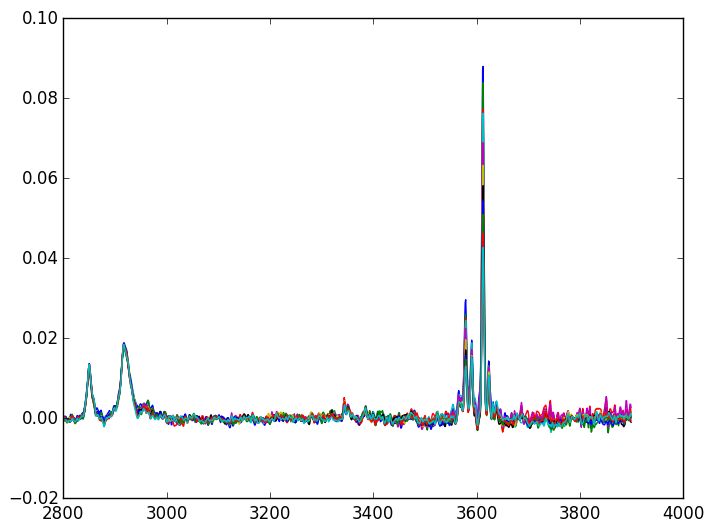

In [31]:
using PyPlot
using JuMP
using Ipopt
using Spectra
using StatsBase

# you need to modify the following three lines
data = readdlm("../Fo_exp6/Fo_exp6_P5.txt", '\t') #reading the data
parameters = readdlm("../Fo_exp6/Fo_exp6_P5_params.txt", '\t') #reading the parametersthe experience details
plot(data[find(2800 .< data[:,1] .<3900),1],data[find(2800 .< data[:,1] .<3900),25:35]) # to select the point of departure of the profil more easily

step = Float64(parameters[1,2]) #step is inputed in metre
time = Float64(parameters[2,2].*3600.0) #time is in seconds, convert the hours of the user input
start_sp = Int64(parameters[3,2]) #first valid spectra along profil (at the border)
stop_sp = Int64(parameters[4,2]) #last valid spectra along profil (at the centre)
low_x = Float64(parameters[5,2]) #low frequency of roi (region of interest)
high_x = Float64(parameters[6,2]) #high frequency of roi (region of interest)
first_bound_norm = Float64(parameters[7,2]) #low bond of integration for normalisation
second_bound_norm = Float64(parameters[8,2]) #high bond of integration for normalisation
first_bound_err = Float64(parameters[9,2]) #low bond of integration for error estimation
last_bound_err = Float64(parameters[10,2]) #high bond of integration for error estimation
m = Int64(parameters[11,2]) #number_peaks
# We read the array of the model parameters and suqeeze them in 1D to have vectors
c0_guess = squeeze(readdlm(IOBuffer(parameters[12,2]),','),1) #Initial concentrations
c1_guess = squeeze(readdlm(IOBuffer(parameters[13,2]),','),1) #Bondary concentrations
D_guess = squeeze(readdlm(IOBuffer(parameters[14,2]),','),1) #Diffisivity coefficients
freq_guess = squeeze(readdlm(IOBuffer(parameters[15,2]),','),1) #Frequencies of the peaks
hwhm_guess = squeeze(readdlm(IOBuffer(parameters[16,2]),','),1) #HWHM of the peaks

println("Done")


In [32]:
# We prepare the data for the fit
x, y, y_ese_r, x_fit, y_fit, ese_fit = IRdataprep(data,step,start_sp,stop_sp,low_x,high_x,first_bound_norm,second_bound_norm, first_bound_err, last_bound_err)

# to avoid any true 0 values and bring y values close to 1
y = y .*10000
y_fit = y_fit .*10000
ese_fit = ese_fit .* 10000

println("Done")
#writedlm("./data_x_debug.txt", x_fit)
#writedlm("./data_y_debug.txt", y_fit)

Done


In [33]:
# number of data =
n = size(x_fit)[1]

mod = Model(solver=IpoptSolver())
#mod1 = Model(solver=NLoptSolver(algorithm=:LN_SBPLX))
#Initial values, m is the number of peaks
@defVar(mod,g_c0[i=1:m] >= 0)
@defVar(mod,g_c1[i=1:m] >= 0)
@defVar(mod, g_D[i=1:m] )
@defVar(mod, g_freq[i=1:m] )
@defVar(mod, g_hwhm[i=1:m] )

# setting the initial values
setValue(g_c0[i=1:m],c0_guess[i])
setValue(g_c1[i=1:m],c1_guess[i])
setValue(g_D[i=1:m],D_guess[i])
setValue(g_freq[i=1:m],freq_guess[i])
setValue(g_hwhm[i=1:m],hwhm_guess[i])

# The generic expression to build the peaks: amplitude of a gaussian peak is calculated from the diffusion of a chemical specie along a diffusion profil
@defNLExpr(mod,g_mod[j=1:n],sum{((g_c1[i] - g_c0[i]) * erfc(x_fit[j,1]/(2. * ( 10^g_D[i] * time)^0.5)) + g_c0[i]) *exp(-log(2) * (x_fit[j,2]-g_freq[i])^2/(g_hwhm[i]^2)), i=1:m})

# The objective function to solve
@setNLObjective(mod,Min,sum{(g_mod[j] - y_fit[j])^2, j=1:n})
println("Constructed...")


Constructed...


We now plot the data to see how looks like the initial model. If not good, we update the above values.

c0 are [0.1,0.1,0.1,0.1,0.1]


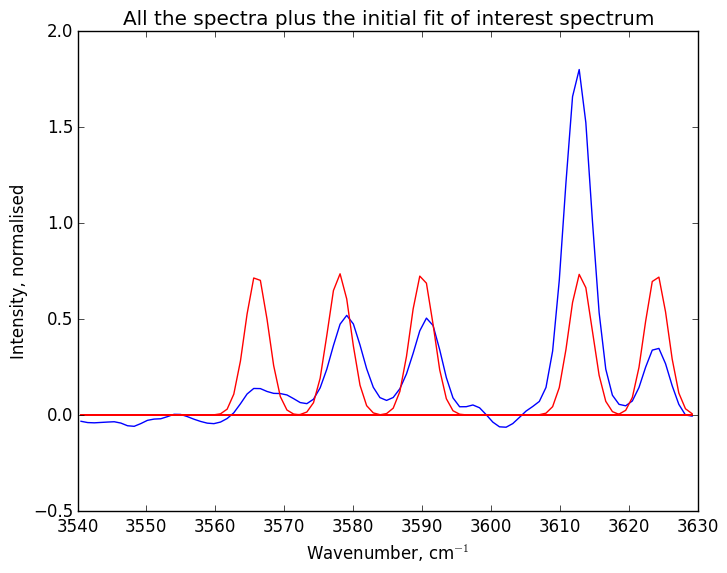

c1 are [1.0,1.0,1.0,1.0,1.0]
D are [-13.0,-13.0,-13.0,-13.0,-13.0]
frequency are [3566.0,3578.0,3590.0,3613.0,3624.0]
hwhm are [2.0,2.0,2.0,2.0,2.0]


In [34]:
# parameter extractions
mod_co = getValue(g_c0)
mod_c1 = getValue(g_c1)
#mod_co = mod_co[:]*(y_max-y_min)+y_min
#mod_c1 = mod_c1[:]*(y_max-y_min)+y_min
mod_D = getValue(g_D)
mod_f = getValue(g_freq)
mod_hwhm = getValue(g_hwhm)

selected_spectrum = 10 #for peak fitting figures
model,peaks = peak_diffusion(mod_co, mod_c1, mod_D, mod_f, mod_hwhm, x_fit, time)
interest_compos = peaks[(selected_spectrum-1)*length(x)+1:(selected_spectrum-1)*length(x)+length(x),:]

fig = figure()
#plot(x, y[:,:],color="black",label="All profil")
plot(x, y[:,selected_spectrum],color="blue",label="SOI")
plot(x,interest_compos[:,:],color="red",label="Guess fit")
title("All the spectra plus the initial fit of interest spectrum")
xlabel(L"Wavenumber, cm$^{-1}$")
ylabel("Intensity, normalised")

println("c0 are $(mod_co)")
println("c1 are $(mod_c1)")
println("D are $(mod_D)")
println("frequency are $(mod_f)")
println("hwhm are $(mod_hwhm)")

And we launch the optimisation procedure with the Ipopt algorithm.

In [35]:
# Solve for the control and state
println("Solving...")
status = solve(mod)

# Display results
println("Solver status: ", status)
println("rmsd: ", getObjectiveValue(mod))

Solving...

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      325

Total number of variables............................:       25
                     variables with only lower bounds:       10
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total num

We have a good solution. Let's see now how things look like:

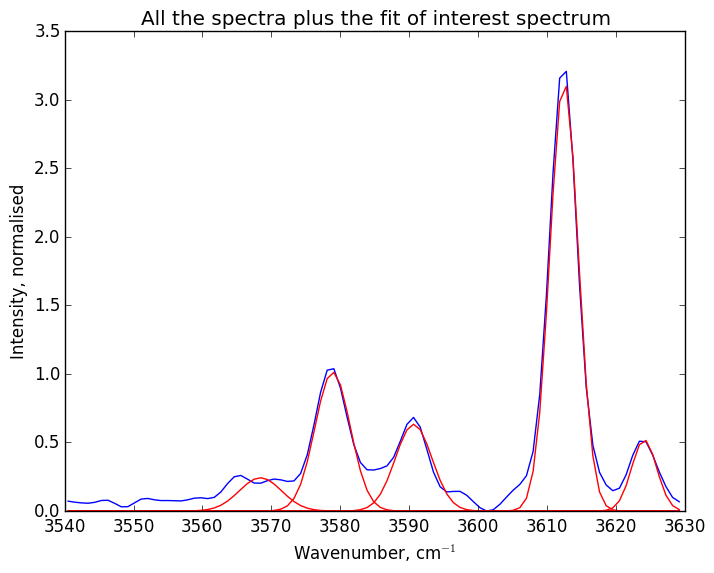

PyObject <matplotlib.text.Text object at 0x322e6c710>


rmsd: 14.590089295490799


In [36]:
# parameter extractions
mod_co_f = getValue(g_c0)
mod_c1_f = getValue(g_c1)
mod_D_f = getValue(g_D)
mod_f_f = getValue(g_freq)
mod_hwhm_f = getValue(g_hwhm)

selected_spectrum = 1 #for peak fitting figures
model,peaks = peak_diffusion(mod_co_f, mod_c1_f, mod_D_f, mod_f_f, mod_hwhm_f, x_fit, time)
interest_compos = peaks[selected_spectrum*length(x)+1:selected_spectrum*length(x)+length(x),:]

fig = figure()
#plot(x, y[:,:],color="black",label="All profil")
plot(x, y[:,selected_spectrum],color="blue",label="SOI")
plot(x,interest_compos[:,:],color="red",label="Guess fit")
title("All the spectra plus the fit of interest spectrum")
xlabel(L"Wavenumber, cm$^{-1}$")
ylabel("Intensity, normalised")

In [37]:
println("c0 are $(mod_co_f)")
println("c1 are $(mod_c1_f)")
println("D are $(mod_D_f)")
println("frequency are $(mod_f_f)")
println("hwhm are $(mod_hwhm_f)")

c0 are [0.05611614105497245,0.025355638429358614,0.32337561780019153,0.0781045935228856,0.2689396811807845]


# Error estimation
Error estimation is made with the Monte Carlo algorithm: (i) we generate X new datasets; (ii) we fit those new dataset with the model and get X sets of parameters; (iii) we calculate the standard deviation of the parameters with the help of those X sets of parameters. This procedure is described in Efron and Tibshinari (1986, Statistical Science 1(1), 54-77).

Three different approaches for generating the new datasets can be adopted:
- resampling with replacement (non-parametric bootstrapping);
- resampling with randomly picking the new datapoints from the distribution of the existing datapoints (assumes a random distribution, with the standard error returned by the function IRdataprep; this is parametric bootstrapping);
- resampling with replacement AND randomly affecting each new point by an error equal to 1/sqrt(n) with n = length(y_fit) (smooth bootstraping).
- resampling with replacement AND randomly affecting each new point by an error generated from the PDF described above OR following a standard deviation equal to 1/sqrt(n) with n = length(y_fit) (smooth bootstraping).

In [45]:
# test unique optimisqtion
# bootstrapping data for errors
nb_boot = 128

params_boot = Array{Float64}(nb_boot,5,m)
#boot_y_fit = bootstrap(y_fit, ese_fit, nb_boot) # this is for some sort of Monte Carlo resampling
vect = collect(1:size(x_fit)[1]) # for real bootstrapping

c0_guess_b = c0_guess
c1_guess_b = c1_guess
D_guess_b = D_guess
freq_guess_b = freq_guess
hwhm_guess_b = hwhm_guess

for k = 1:nb_boot
    
    # bootstrap by resampling y_fit with replacement...
    idx = sample(vect,size(vect)[1])
    b_y_f = y_fit[idx,:]
    b_x_f = x_fit[idx,:] # turn to x_fit directly if Monte Carlo resampling and not bootstrapping
    
    # to be safe we re-define the model
    modb = Model(solver=IpoptSolver(print_level=0))

    @defVar(modb,g_c0_b[i=1:m] >= 0) #Initial values, m is the number of peaks
    @defVar(modb,g_c1_b[i=1:m] >= 0)
    @defVar(modb, g_D_b[i=1:m] )
    @defVar(modb, g_freq_b[i=1:m] )
    @defVar(modb, g_hwhm_b[i=1:m] >= 0 )

    # setting the initial values
    setValue(g_c0_b[i=1:m],c0_guess_b[i])
    setValue(g_c1_b[i=1:m],c1_guess_b[i])
    setValue(g_D_b[i=1:m],D_guess_b[i])
    setValue(g_freq_b[i=1:m],freq_guess_b[i])
    setValue(g_hwhm_b[i=1:m],hwhm_guess_b[i])
    
    # The generic expression to build the peaks: amplitude of a gaussian peak is calculated from the diffusion of a chemical specie along a diffusion profil
    @defNLExpr(modb,g_mod_b[j=1:n],sum{((g_c1_b[i] - g_c0_b[i]) * erfc(b_x_f[j,1]/(2. * ( 10^g_D_b[i] * time)^0.5)) + g_c0_b[i]) *exp(-log(2) * (b_x_f[j,2]-g_freq_b[i])^2/(g_hwhm_b[i]^2)), i=1:m})

    @setNLObjective(modb,Min,sum{(g_mod_b[j] - b_y_f[j])^2,j=1:n})
    status = solve(modb)
    println("Solver status: ", status)
    
    params_boot[k,1,:] = getValue(g_c0_b)
    params_boot[k,2,:] = getValue(g_c1_b)
    params_boot[k,3,:] = getValue(g_D_b)
    params_boot[k,4,:] = getValue(g_freq_b)
    params_boot[k,5,:] = getValue(g_hwhm_b)
end
        

println("Done...")


Solver status: Optimal
Solver status: Optimal
Solver status: Optimal
Solver status: Optimal
Solver status: Optimal
Solver status: Optimal
Solver status: Optimal
Solver status: Optimal
Solver status: Optimal
Solver status: Optimal
Solver status: Optimal
Solver status: Optimal
Solver status: Optimal
Solver status: Optimal
Solver status: Optimal
Solver status: Optimal
Solver status: Optimal
Solver status: Optimal
Solver status: Optimal
Solver status: Optimal
Solver status: Optimal
Solver status: Optimal
Solver status: Optimal
Solver status: Optimal
Solver status: Optimal
Solver status: Optimal
Solver status: Optimal
Solver status: Optimal
Solver status: Optimal
Solver status: Optimal
Solver status: Optimal
Solver status: Optimal
Solver status: Optimal
Solver status: Optimal
Solver status: Optimal
Solver status: Optimal
Solver status: Optimal
Solver status: Optimal
Solver status: Optimal
Solver status: Optimal
Solver status: Optimal
Solver status: Optimal
Solver status: Optimal
Solver stat

From bootstrapping, values for peak 1:


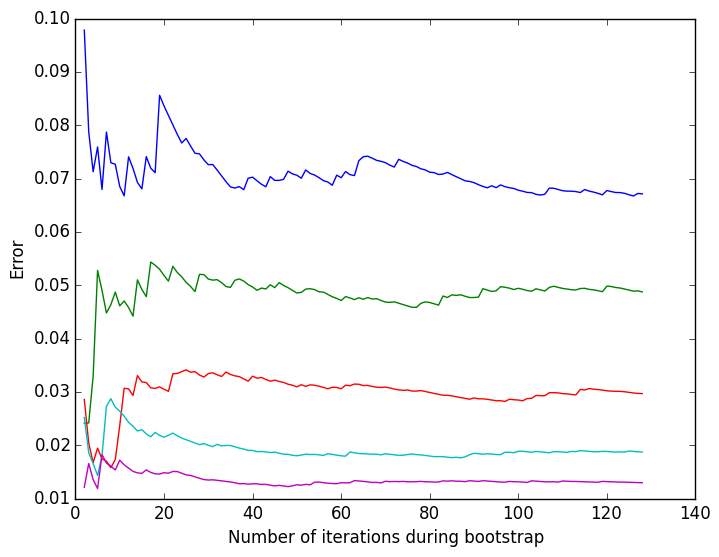

PyObject <matplotlib.text.Text object at 0x32384e290>

c0 mean [0.05612097846013093] and std [0.0012516504012213092]
c1 mean [0.2554385477246934] and std [0.011296254496231083]
D mean [-13.621126925286918] and std [0.04542995031664597]
frequency mean [3568.4196141605976] and std [0.07908715223382694]
hwhm mean [3.600703599906714] and std [0.06712049140097005]

From bootstrapping, values for peak 2:
c0 mean [0.02526477463581847] and std [0.0006958015982706467]
c1 mean [1.0814284832414631] and std [0.014303724326714127]
D mean [-13.584649459254322] and std [0.009554391279919281]
frequency mean [3578.901258435964] and std [0.031049259828681373]
hwhm mean [3.02153453755638] and std [0.04873259899908261]

From bootstrapping, values for peak 3:
c0 mean [0.3232864332107633] and std [0.0018201055767423063]
c1 mean [0.6603193505594033] and std [0.012383879505767754]
D mean [-13.806436669518684] and std [0.04256234112101044]
frequency mean [3590.6550339436217] and std [0.014861499255957323]
hwhm mean [3.140849478800933] and std [0.029665137736299384

In [60]:
for i = 1:m
    println("From bootstrapping, values for peak $(i):")
    println("c0 mean $(mean(params_boot[:,1,i],1)) and std $(std(params_boot[:,1,i],1))")
    println("c1 mean $(mean(params_boot[:,2,i],1)) and std $(std(params_boot[:,2,i],1))")
    println("D mean $(mean(params_boot[:,3,i],1)) and std $(std(params_boot[:,3,i],1))")
    println("frequency mean $(mean(params_boot[:,4,i],1)) and std $(std(params_boot[:,4,i],1))")
    println("hwhm mean $(mean(params_boot[:,5,i],1)) and std $(std(params_boot[:,5,i],1))")
    println("")
end

# bootstrap performance
#peak_interest_boot_stat = 1 # choose the peak
param_interest_boot_stat = 5 # choose the parameter

bootrecord = zeros(nb_boot,m)
for k = 1:nb_boot
    for i = 1:m
        if k == 0
            bootrecord[k,i] = 0
        else
            bootrecord[k,i] = sum(std(params_boot[1:k,param_interest_boot_stat,i],1))
        end
    end
end

fig = figure()
for i = 1:m
    plot(1:nb_boot, bootrecord[:,i],label="SOI")
end
xlabel("Number of iterations during bootstrap")
ylabel("Error")


In [55]:
params_boot[1,3,1]

-13.562111948981032

In [40]:
idx = sample(vect,size(vect))

14229-element Array{Int64,1}:
  2494
 13298
  7661
   159
  4144
  1019
  1735
  2805
  2154
 11247
  7105
 11325
  1277
     ⋮
 13733
 13545
 12164
  4022
  7113
  1586
  5215
  7304
  3622
  3771
 10647
  9135